In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, r2_score
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
import pickle as pkl
from sklearn.linear_model import LassoCV

np.random.seed(42)

In [2]:
train_data = pd.read_csv("handout/train_features.csv", delimiter=",")
train_labels = pd.read_csv("handout/train_labels.csv", delimiter=",")
test_data = pd.read_csv("handout/test_features.csv", delimiter=",")

train_data = train_data.sort_values(['pid','Time'])
train_labels = train_labels.sort_values(['pid'])
test_data = test_data.sort_values(['pid','Time'])

In [3]:
# new feature that keeps track of wheter or not a certain feature was present
for col in train_data.columns[3:]:
    train_data[f"{col}_notna"] = train_data[col].notna().astype(int)

for col in test_data.columns[3:]:
    test_data[f"{col}_notna"] = test_data[col].notna().astype(int)

In [4]:
# substitute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_data)
train_data_implaced = imputer.transform(train_data)
train_data_implaced = pd.DataFrame(train_data_implaced, columns=train_data.columns)

imputer = SimpleImputer(strategy='mean')
imputer.fit(test_data)
test_data_implaced = imputer.transform(test_data)
test_data_implaced = pd.DataFrame(test_data_implaced, columns=test_data.columns)

In [5]:
# normalize
for col in train_data_implaced.columns[2:]:
    train_data_implaced[col] = (train_data_implaced[col] - train_data_implaced[col].min()) / (train_data_implaced[col].max() - train_data_implaced[col].min())

for col in test_data_implaced.columns[2:]:
    test_data_implaced[col] = (test_data_implaced[col] - test_data_implaced[col].min()) / (test_data_implaced[col].max() - test_data_implaced[col].min())

In [6]:
# same values for time
train_data_implaced["Time"] = list(range(1, 13)) * len(list(set(train_data_implaced["pid"])))
test_data_implaced["Time"] = list(range(1, 13)) * len(list(set(test_data_implaced["pid"])))

In [7]:
# pivot
train_data_pivoted = train_data_implaced.pivot(index="pid", columns="Time", values=train_data_implaced.columns[2:])
test_data_pivoted = test_data_implaced.pivot(index="pid", columns="Time", values=test_data_implaced.columns[2:])

In [8]:
train_labels = train_labels.set_index("pid")
train_labels = train_labels.sort_index()

In [10]:
def balance_dataset(train_data, train_labels, label):
    train_data_0 = train_data[train_labels[label] == 0]
    train_data_1 = train_data[train_labels[label] == 1]

    n = min(train_data_0.shape[0], train_data_1.shape[0])
    train_data_ok = pd.concat([train_data_0.sample(n), train_data_1.sample(n)])
    train_data_ok = shuffle(train_data_ok)

    train_labels_ok = train_labels.loc[train_data_ok.index, label]

    return train_data_ok, train_labels_ok

In [28]:
labels = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
# only to test
#labels = ["LABEL_BaseExcess"]

## Subtask 1

LABEL_BaseExcess
ROC AUC: 0.9282692444613784
LABEL_Fibrinogen
ROC AUC: 0.8336479953055835
LABEL_AST
ROC AUC: 0.753567848157395
LABEL_Alkalinephos
ROC AUC: 0.7435386870104406
LABEL_Bilirubin_total
ROC AUC: 0.7451448044971413
LABEL_Lactate
ROC AUC: 0.8265162151567117
LABEL_TroponinI
ROC AUC: 0.8573839662447257
LABEL_SaO2
ROC AUC: 0.8441765968132219
LABEL_Bilirubin_direct
ROC AUC: 0.8143098966205187
LABEL_EtCO2
ROC AUC: 0.9434765345827046


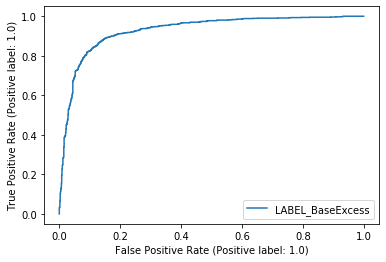

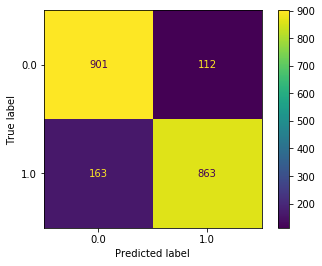

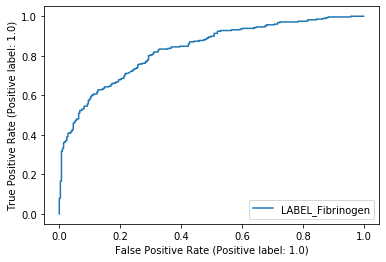

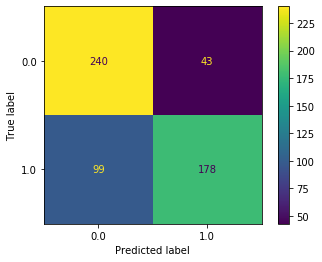

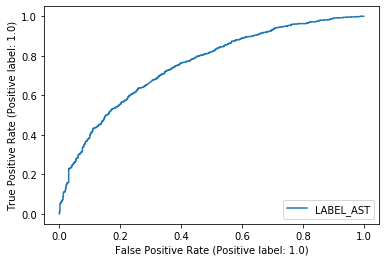

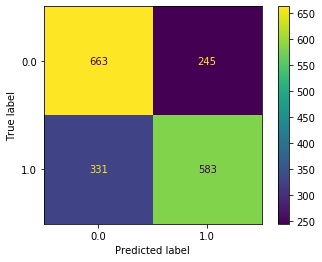

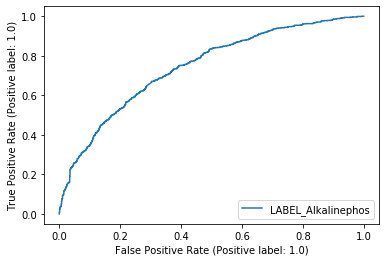

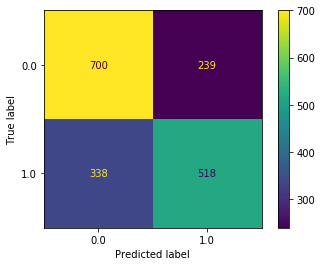

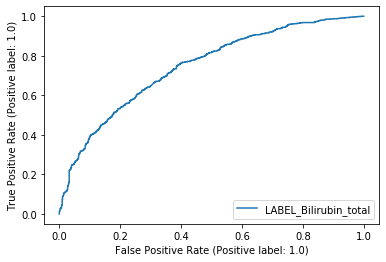

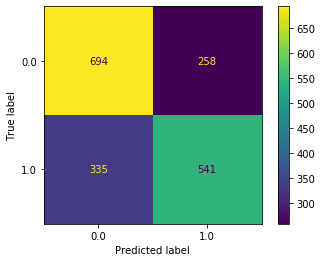

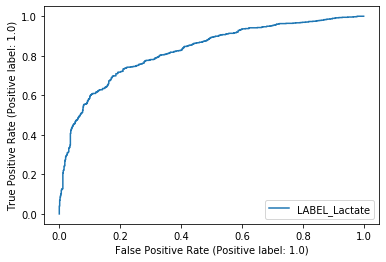

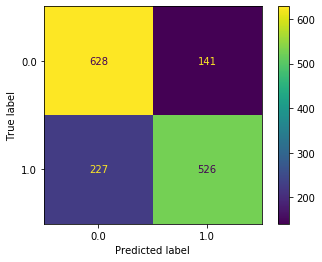

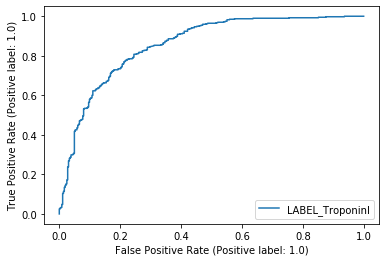

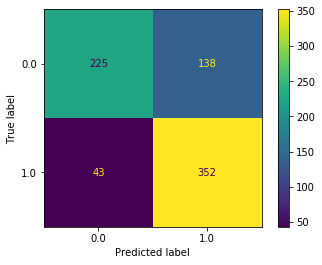

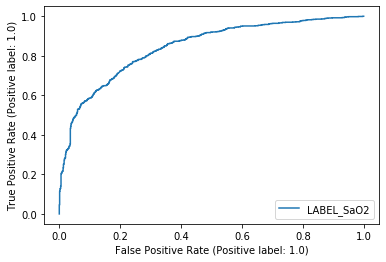

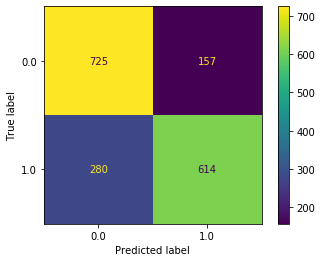

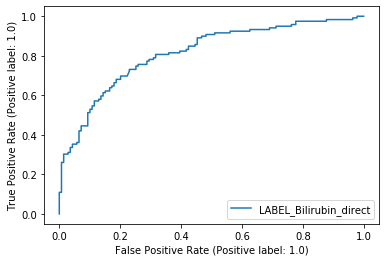

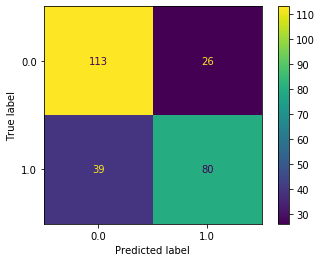

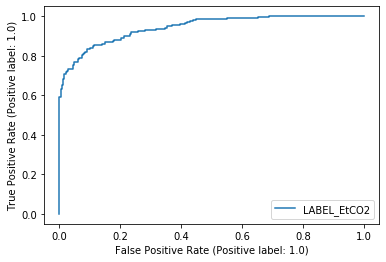

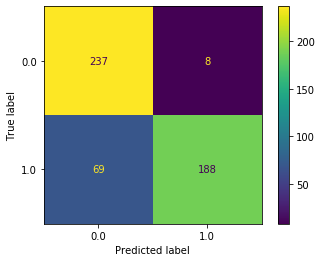

In [15]:
for label in labels:
    train_data_balanced, train_labels_balanced = balance_dataset(train_data_pivoted, train_labels, label)
    X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)

    try:
        with open("models/{}.pkl".format(label), "rb") as f:
            clf = pkl.load(f)
    except:
        clf = svm.SVC(probability=True)
        clf.fit(X_train, y_train)
        with open("models/{}.pkl".format(label), "wb") as f:
            pkl.dump(clf, f)
    
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Evaluation
    print(label)
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
    plot_roc_curve(clf, X_test, y_test, label=label)
    plot_confusion_matrix(clf, X_test, y_test);

## Subtask 2

In [12]:
label = "LABEL_Sepsis"

LABEL_Sepsis
ROC AUC: 0.7684959178520326


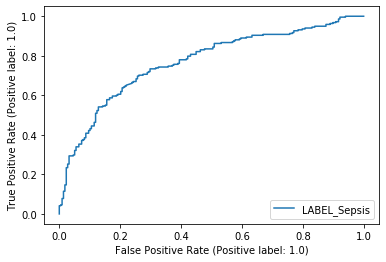

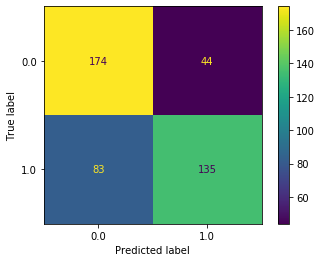

In [14]:
train_data_balanced, train_labels_balanced = balance_dataset(train_data_pivoted, train_labels, label)
X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)

try:
    with open("models/{}.pkl".format(label), "rb") as f:
        clf = pkl.load(f)
except:
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)
    with open("models/{}.pkl".format(label), "wb") as f:
        pkl.dump(clf, f)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print(label)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
plot_roc_curve(clf, X_test, y_test, label=label)
plot_confusion_matrix(clf, X_test, y_test);

## Subtask 3

In [17]:
labels = ["LABEL_RRate", "LABEL_ABPm", "LABEL_SpO2", "LABEL_Heartrate"]
# to test
labels = ["LABEL_RRate"]

In [26]:
for label in labels:
    train_labels_single = train_labels[label]
    X_train, X_test, y_train, y_test = train_test_split(train_data_pivoted, train_labels_single, test_size=0.2, random_state=42)

    try:
        with open("models/{}.pkl".format(label), "rb") as f:
            regressor = pkl.load(f)
    except:
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
        regressor = LassoCV(alphas=np.linspace(0.00001, 1, 1000), max_iter=10000, cv=cv)
        regressor.fit(X_train, y_train)
        with open("models/{}.pkl".format(label), "wb") as f:
            pkl.dump(regressor, f)
    
    y_pred = regressor.predict(X_test)

    # Evaluation
    print(label)
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2}")

LABEL_RRate
R2: 0.43964747275007754
LABEL_ABPm
R2: 0.6271991021843828
LABEL_SpO2
R2: 0.39806638497076374
LABEL_Heartrate
R2: 0.6443348847795811


Apply all models to test data and dump the results

In [107]:
labels_t1 = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
labels_t2 = ["LABEL_Sepsis"]
labels_t3 = ["LABEL_RRate", "LABEL_ABPm", "LABEL_SpO2", "LABEL_Heartrate"]

output = pd.DataFrame()
output["pid"] = test_data_pivoted.index.astype(int)
for label in labels_t1 + labels_t2:
    print(label)
    with open("models/{}.pkl".format(label), "rb") as f:
        clf = pkl.load(f)
    y_pred = clf.predict_proba(test_data_pivoted)[:, 1]
    output[label] = y_pred

for label in labels_t3:
    print(label)
    with open("models/{}.pkl".format(label), "rb") as f:
        regressor = pkl.load(f)
    y_pred = regressor.predict(test_data_pivoted)
    output[label] = y_pred

LABEL_BaseExcess
LABEL_Fibrinogen
LABEL_AST
LABEL_Alkalinephos
LABEL_Bilirubin_total
LABEL_Lactate
LABEL_TroponinI
LABEL_SaO2
LABEL_Bilirubin_direct
LABEL_EtCO2
LABEL_Sepsis
LABEL_RRate
LABEL_ABPm
LABEL_SpO2
LABEL_Heartrate


In [122]:
sample_data = pd.read_csv("handout/sample.zip", delimiter=",")

output_t = output.set_index("pid")
output_t = output_t.reindex(sample_data["pid"].to_numpy())
output_t = output_t.reset_index()
output_t = output_t.rename(columns={"index": "pid"})
output_t.to_csv('task2_masgalli.zip', index=False, float_format='%.3f', compression='zip')